In [1]:
import sys
sys.path.insert(0, '..')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary

from dataset import CelebADataset
from models.wgan import (
    Discriminator,
    Generator,
    WGAN
)
from utils import display_grid

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cuda


# 0. Parameters

In [12]:
IMAGE_SIZE = 64
CHANNELS = 3
BATCH_SIZE = 32
Z_DIM = 200
EPOCHS = 10
LR = 1e-4
LOAD_MODEL = True

# 1. Prepare the data

In [5]:
data_path = '../celeba/'

data = CelebADataset(data_path=data_path,
                     batch_size=BATCH_SIZE,
                     num_workers=16,
                     pin_memory=True)
# Uncomment if you haven't downloaded the dataset.
# data.prepare_data()
data.setup()

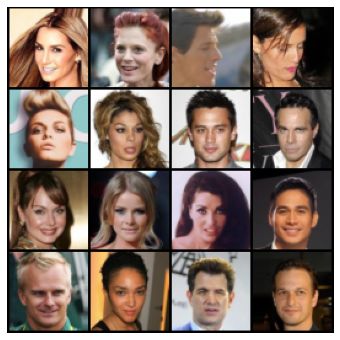

In [6]:
data_head = torch.stack([data.celeba_train[i][0] for i in range(16)])
display_grid(data_head, nrow=4, figsize=(6, 6))

# 2. Build WGAN

## Generator

In [7]:
g = Generator(channels=3, latent_dim=128)

In [8]:
summary(g, (32, 128))

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [32, 3, 64, 64]           --
├─Sequential: 1-1                        [32, 4096]                --
│    └─Linear: 2-1                       [32, 4096]                528,384
│    └─ReLU: 2-2                         [32, 4096]                --
├─Sequential: 1-2                        [32, 3, 64, 64]           --
│    └─Sequential: 2-3                   [32, 128, 8, 8]           --
│    │    └─ConvTranspose2d: 3-1         [32, 128, 8, 8]           524,416
│    │    └─BatchNorm2d: 3-2             [32, 128, 8, 8]           256
│    │    └─LeakyReLU: 3-3               [32, 128, 8, 8]           --
│    └─Sequential: 2-4                   [32, 64, 16, 16]          --
│    │    └─ConvTranspose2d: 3-4         [32, 64, 16, 16]          131,136
│    │    └─BatchNorm2d: 3-5             [32, 64, 16, 16]          128
│    │    └─LeakyReLU: 3-6               [32, 64, 16, 16]          -

## Discriminator

In [9]:
d = Discriminator(channels=3)

In [10]:
summary(d, (1, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [1, 1]                    --
├─Sequential: 1-1                        [1, 256, 2, 2]            --
│    └─Sequential: 2-1                   [1, 16, 32, 32]           --
│    │    └─Conv2d: 3-1                  [1, 16, 32, 32]           784
│    │    └─LeakyReLU: 3-2               [1, 16, 32, 32]           --
│    └─Sequential: 2-2                   [1, 32, 16, 16]           --
│    │    └─Conv2d: 3-3                  [1, 32, 16, 16]           8,224
│    │    └─LeakyReLU: 3-4               [1, 32, 16, 16]           --
│    └─Sequential: 2-3                   [1, 64, 8, 8]             --
│    │    └─Conv2d: 3-5                  [1, 64, 8, 8]             32,832
│    │    └─LeakyReLU: 3-6               [1, 64, 8, 8]             --
│    └─Sequential: 2-4                   [1, 128, 4, 4]            --
│    │    └─Conv2d: 3-7                  [1, 128, 4, 4]            131,200
│ 

## WGAN-GP

In [15]:
model_params = {
    'channels': 3,
    'latent_dim': 128,
    'critic_steps': 5,
    'gp_lambda': 10,
    'd_lr': 0.0001,
    'g_lr': 0.0001
}
model_path = '../logs/WGAN/version_17/checkpoints/epoch=399-step=305600.ckpt'

wgan = WGAN(**model_params)
if LOAD_MODEL:
    print('Loading model from checkpoint.')
    wgan = WGAN.load_from_checkpoint(model_path, **model_params)

Loading model from checkpoint.


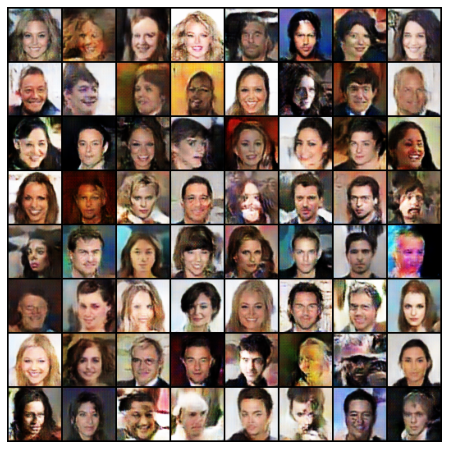

In [17]:
NUM_SAMPLES = 64

generated_images = wgan.sample_G(64)

display_grid(generated_images, figsize=(8,8))
plt.savefig('vae_reconstruction.png', bbox_inches='tight', pad_inches=0, dpi=156)
plt.show()